### **1. Import Dependencies**

In [1]:
import pandas as pd
import numpy as np

from collections import Counter

import gc
import os
import requests
import json
import re

import concurrent.futures

from urllib.parse import urlencode

from typing import List, Dict, Optional, Union
from glob import glob

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score, recall_score, f1_score

from sentence_transformers import SentenceTransformer
from gensim.models import KeyedVectors 

import tensorflow as tf
import tensorflow.keras as keras

from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Bidirectional, Input, Reshape, Dot, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping

import faiss

from imblearn.over_sampling import RandomOverSampler

nltk.download('stopwords')
nltk.download('punkt')

d:\Project\Python\End to End Projects\Bug Classification\Notebook\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msi.pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\msi.pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **2. Settings**

In [2]:
tf.random.set_seed(42)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

### **3. Load Data**

Fetch the bug report data using [BugZilla API](https://bmo.readthedocs.io/en/latest/api/core/v1/bug.html#get-bug) then save it as json and Pandas.parquet.

In [17]:
def fetch_data(url: str, params=None):
  try:
    response = requests.get(url, params=params)
    if (response.status_code == 200):
      return response.json()
    
    print(f"Error response with status code: {response.status_code}")
  except Exception as error:
    print(f'Failed to fetch data: {error}')


def urls_builder(base_url: str, n_fetch: int, limit: int, products: List[str], **kwargs):
  urls = []
  for product in products:
    for i in range(n_fetch):
      param = {'offset': i * limit, 'limit': limit, 'product': product, **kwargs}
      full_url = base_url + '?' + urlencode(param)
      urls.append(full_url)
    
  return urls


def save_json(data, path: str):
  with open(path, 'w') as json_file:
    json.dump(data, json_file)


def load_json(path: str):
  with open(path, 'r') as json_file:
    loaded_data = json.load(json_file)
  return loaded_data

In [17]:
%%script skipped # Skipped

selected_fields = ['id', 'duplicates', 'summary', 'description', 'status', 'resolution', 'platform', 'product', 'type', 'priority', 'severity', 'component']
products = ['Firefox']

base_params = {'include_fields': ', '.join(selected_fields)}
saved_data_path = os.path.join('data', 'raw_data', 'firefox_raw_data.json')

base_url = 'https://bugzilla.mozilla.org/rest/bug'
n_fetch, limit = 50, 100

if os.path.exists(saved_data_path):
  response_data = load_json(saved_data_path)
else:
  urls = urls_builder(base_url, n_fetch, limit, products, **base_params)
  response_data = []

  max_workers = 50
  with concurrent.futures.ThreadPoolExecutor(max_workers) as executor:
    response_data = list(executor.map(fetch_data, urls))
    
  response_data = [item['bugs'] for item in response_data]
  response_data = [item for sublist in response_data for item in sublist]
  
  save_json(response_data, saved_data_path)

In [18]:
raw_data_path = os.path.join('data', 'cache', 'raw_data.parquet')
df = pd.DataFrame()

if (os.path.exists(raw_data_path)):
  df = pd.read_parquet(raw_data_path)
else:
  data_paths = glob(os.path.join('data', 'raw_data', '*.json'))

  for path in data_paths:
    data = load_json(path)
    data = pd.DataFrame(data)
    df = pd.concat([df, data])

  df = df.set_index('id')
  df.to_parquet(raw_data_path)

df.head()

,priority,type,status,severity,product,description,resolution,duplicates,component,platform,summary
id,,,,,,,,,,,
91,P3,defect,VERIFIED,major,Core,Created by Till Krech (till@berlin.snafu.de) o...,FIXED,[],DOM: Core & HTML,x86,document properties cannot be listed
103,P1,defect,VERIFIED,normal,Core,Created by Darrell Kindred (dkindred=mozilla@c...,FIXED,[],Layout: Tables,x86,layout bug: table cell overflows containing cell
104,P3,defect,VERIFIED,minor,Core,Created by Darrell Kindred (dkindred=mozilla@c...,WONTFIX,[],DOM: Serializers,x86,table saved as text: missing inter-column space
105,P2,defect,VERIFIED,normal,Core,"Created by (msuencks@marcant.de) on Tuesday,...",FIXED,[],Layout: Tables,x86,nested <TABLE>s: bgcolor of inner table not re...
133,P3,defect,VERIFIED,minor,Core,Created by Boris Tobotras (boris@xtalk.msk.su)...,FIXED,[],Internationalization,All,Navigator draws entities like &lt;&amp;&gt; as...


In [19]:
df = df.drop(['status', 'priority', 'resolution', 'severity', 'type'], axis=1)

gc.collect()

0

In [20]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 710693 entries, 91 to 1876223
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   product      710693 non-null  object
 1   description  710693 non-null  object
 2   duplicates   710693 non-null  object
 3   component    710693 non-null  object
 4   platform     710693 non-null  object
 5   summary      710693 non-null  object
dtypes: object(6)
memory usage: 1.3 GB


### **3. EDA**

### **3.1. Missing Values**

It seems there is no missing value

In [21]:
df.isna().sum()

product        0
description    0
duplicates     0
component      0
platform       0
summary        0
dtype: int64

### **3.2. Product (Skipped)**

In [16]:
%%script skipped # Skipped

df['product'].value_counts(ascending=False)

product
Core       500000
Firefox    210693
Name: count, dtype: int64

### **3.3. Platform**

In [22]:
df['platform'].value_counts(ascending=False)

platform
Unspecified    237419
x86            207583
All            167509
x86_64          58191
PowerPC         13960
Desktop         10684
ARM              9370
Other            3171
Sun              1477
ARM64             883
DEC               201
HP                134
SGI                80
RISCV64            28
XScale              3
Name: count, dtype: int64

### **3.4. Type (Skipped)**

In [13]:
%%script skipped # Skipped

df['type'].value_counts(ascending=False)

Couldn't find program: 'skipped'


### **3.5. Duplicates**

We see that there are 15k bug reports are considered duplicated by other reports

In [23]:
duplicates = df['duplicates'].apply(lambda x: len(x)).sort_values(ascending=False)

duplicated_bugs = duplicates[duplicates > 0]

print(f'total of duplicated bugs: {duplicated_bugs.count()}')

total of duplicated bugs: 61367


### **4. Feature Engineering**

### **4.1. Missing Values (Skipped)**

In [32]:
%%script skipped # Skipped

df.loc[df['type'] == '--', 'type'] = 'no type'

Couldn't find program: 'skipped'


### **4.2. Duplicates**

In [24]:
df = df.loc[df.astype(str).drop_duplicates(keep='first').index]

### **4.2. Duplicates**

Currently we have data that has field called `'duplicates'` which is a list of report ids that considered has the same context. To make the data usable, add new feature called `'duplicates_to'` that inferred from `'duplicates'` field.

In [25]:
duplicated = df.loc[duplicated_bugs.index, 'duplicates']
duplicated

id
171441     [152619, 155407, 169276, 171588, 171649, 17171...
1392106    [1384501, 1393296, 1407762, 1424790, 1427728, ...
22274      [18941, 19956, 20575, 40355, 44978, 46299, 469...
82534      [84921, 87390, 87452, 87479, 91757, 94869, 100...
25537      [50727, 61222, 66282, 67093, 74376, 78575, 799...
                                 ...                        
1458553                                            [1448420]
1603979                                            [1604107]
426009                                              [425931]
55881                                                [55901]
60787                                               [813510]
Name: duplicates, Length: 61367, dtype: object

In [4]:
data_path = os.path.join('data', 'cache', 'duplicate_to_data.parquet')

if (os.path.exists(data_path)):
  df = pd.read_parquet(data_path)
else:
  df['duplicates_to'] = -1

  for idx, dups in zip(duplicated.index, duplicated):
    for item in dups:
      df.loc[df.index == item, 'duplicates_to'] = idx
      
  df.to_parquet(data_path)

In [5]:
df = df.drop(columns=['duplicates'])
gc.collect()

### **4.4. Combined Text**

In [6]:
df['text'] = df['platform'] + ' ' + df['component'] + ' ' + df['summary']

In [7]:
df = df[['text', 'duplicates_to']]

df.head()

,text,duplicates_to
id,,
91,x86 DOM: Core & HTML document properties canno...,-1
103,x86 Layout: Tables layout bug: table cell over...,-1
104,x86 DOM: Serializers table saved as text: miss...,-1
105,x86 Layout: Tables nested <TABLE>s: bgcolor of...,-1
133,All Internationalization Navigator draws entit...,-1


In [12]:
total_duplicates = df['duplicates_to']
total_duplicates = total_duplicates[total_duplicates != -1].count()

print(f'total duplicates report: {total_duplicates}')

total duplicates report: 106919


### **4.3. Clean Sentences**

Remove non-alphanumeric, newline, tab, return, single character, and multiple spaces. We also removing stopwords by utilizing stopwords provided by `nltk` library 

In [4]:
def remove_special_chars(text: str):
  text = text.lower()
  text = re.sub(r'\n|\t|\r|\0', ' ', text)
  text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
  text = re.sub(r'\s{2,}', ' ', text)
  text = re.sub(r'\s$', '', text)
  text = re.sub(r'\s[b-z]\s', ' ', text)
  text = re.sub(r'\s[b-z]\s', ' ', text)
  text = re.sub(r'\s{2,}', ' ', text)
  return text


def remove_stopwords(text: str):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  filtered_words = [word for word in words if word not in stop_words]
  return ' '.join(filtered_words)


def clean_text(text: str):
  text = remove_special_chars(text)
  text = remove_stopwords(text)
  return text


data_path = os.path.join('data', 'cache', 'cleaned_text_data.parquet')

if (os.path.exists(data_path)):
  df = pd.read_parquet(data_path)
else:
  df['text'] = df['text'].apply(clean_text)
  df.to_parquet(data_path)

### **4.5. Sentence Embedding**

We use pretrained embedding model to vectorize the text, there are 2 methods that we try in this project, **Sentence Transformer (all-MiniLM-L6-v2)** and **Fasttext**.

### **4.5.1. Sentence Transformers**

Based on the [all-MiniLM-L6-v2 page](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), we know that all-MiniLM-L6-v2 use 384 dense vector to represent a sentence. This model intended to be used as a sentence and short paragraph encoder that limited to 256 word pieces (longer that that will be truncated) that means, *there are some text will not be able to vectorize with full context*.

In [5]:
# %%script skipped # Skipped
sent_embd_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [3]:
# %%script skipped # Skipped

num_dim = 384
embd_data_path = os.path.join('data', 'cache', 'sent_trans_embd_data.parquet')

if (os.path.exists(embd_data_path)):
  df = pd.read_parquet(embd_data_path)
else:
  df['text_embedded'] = df['text'].apply(sent_embd_model.encode)
  df.to_parquet(embd_data_path)

df['text_embedded'] = df['text_embedded'].apply(np.array)
gc.collect()

43

### **4.5.2. Fasttext**

Basically `Fasttext` is used for word embedding, to get sentence vector, we simply use normalized average word vector among sentence. Normalization used because our objective is to determining similarity between texts/sentences. The advantages of using `Fasttext` besides it much faster, we also able to capture full context on every sentence because there is no sentence length limitation.

In [17]:
%%script skipped # Skipped

model_path = os.path.join('pretrained_models', 'wiki-news-300d-1M-subword.vec')
sent_embd_model = KeyedVectors.load_word2vec_format(model_path, binary=False)

In [18]:
%%script skipped # Skipped

def sentence_embedding(sentence, model):
    words = word_tokenize(sentence)
    words_in_vocab = [word for word in words if word in model]

    if not words_in_vocab:
        return None

    embedding = np.mean([model[word] for word in words_in_vocab], axis=0)
    embedding = normalize(embedding.reshape(1, -1), norm='l2').reshape(-1)

    return embedding

In [167]:
%%script skipped # Skipped

num_dim = 300
embd_data_path = os.path.join('data', 'cache', 'fasttext_embd_data.parquet')

if (os.path.exists(embd_data_path)):
  df = pd.read_parquet(embd_data_path)
else:
  df['text_embedded'] = df['text'].apply(sentence_embedding, model=sent_embd_model)
  df.to_parquet(embd_data_path)

df['text_embedded'] = df['text_embedded'].apply(np.array)
gc.collect()

20005

In [10]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 709953 entries, 91 to 1876223
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   text           709953 non-null  object
 1   duplicates_to  709953 non-null  int64 
 2   text_embedded  709953 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2 GB


### **4.6. Sentence Pairs**

We create sentence pairs and label them whether both unique or (same) duplicated report

In [4]:
df = df.reset_index()

In [5]:
df_duplicate_pairs = df[df['duplicates_to'] != -1].copy()
df_unique_pairs = df[df['duplicates_to'] == -1].copy()

In [6]:
df_duplicate_pairs = pd.merge(left=df_duplicate_pairs,
                        right=df_unique_pairs,
                        left_on='duplicates_to',
                        right_on='id',
                        suffixes=('__left', '__right'))
df_duplicate_pairs = df_duplicate_pairs.drop(columns=['duplicates_to__left', 'duplicates_to__right'])
df_duplicate_pairs['label'] = 1
df_duplicate_pairs = df_duplicate_pairs.reset_index(drop=True)

df_duplicate_pairs.head()

,id__left,text__left,text_embedded__left,id__right,text__right,text_embedded__right,label
0,273,x86 xul submenu open delay wrong windows,"[0.009231214, -0.056730874, 0.02627475, 0.0123...",24514,x86 xul tweak open delay use os setting,"[0.03783767, -0.015200045, -0.022235006, 0.032...",1
1,414,x86 javascript engine resizing browser href fu...,"[-0.038329743, 0.0071658525, 0.048500344, 0.03...",415,x86 javascript engine resizing browser href fu...,"[-0.038329743, 0.0071658525, 0.048500344, 0.03...",1
2,466,layout font stacks parsing algorithm bug,"[-0.08694876, -0.010136366, 0.038810704, -0.00...",991,x86 dom html parser dogfood 4 xp font tags con...,"[-0.009354677, -0.012226332, 0.04828655, -0.03...",1
3,599,x86 networking ftp ss ftp directories displaying,"[0.045445204, -0.026756555, -0.029333267, 0.05...",1533,x86 networking ftp ftp urls crash 11 23 98 xpv...,"[-0.012797209, -0.006409554, 0.019315422, -0.0...",1
4,603,x86 layout script src work,"[-0.015569594, -0.017515322, -0.034079563, -0....",1433,x86 layout page loading synchronous embedded s...,"[-0.038522158, 0.040723607, 0.013081141, 0.005...",1


In [7]:
half_rows = df_unique_pairs.shape[0] // 2
df_unique_pairs = df_unique_pairs.sample(frac=1, replace=False, random_state=42)

_df_unique_pairs = pd.DataFrame()
_df_unique_pairs['text_embedded__left'] = df_unique_pairs['text_embedded']
_df_unique_pairs['text__left'] = df_unique_pairs['text']
_df_unique_pairs['id__left'] = df_unique_pairs['id']

_df_unique_pairs['text_embedded__right'] = df_unique_pairs['text_embedded'].shift(1)
_df_unique_pairs['text__right'] = df_unique_pairs['text'].shift(1)
_df_unique_pairs['id__right'] = df_unique_pairs['id'].shift(1)

_df_unique_pairs = _df_unique_pairs.dropna()
_df_unique_pairs['label'] = 0

df_unique_pairs = _df_unique_pairs.reset_index(drop=True)

del _df_unique_pairs
gc.collect()

df_unique_pairs.head()

,text_embedded__left,text__left,id__left,text_embedded__right,text__right,id__right,label
0,"[0.0037959728, -0.035022546, -0.021059414, -0....",unspecified panning zooming use isrootcontentd...,1728665,"[-0.046126463, 0.07969776, -0.008310649, -0.02...",desktop security psm meta tls 1 0 1 1 deprecat...,1616494.0,0
1,"[0.0060888575, 0.019317826, 0.022315515, 0.033...",unspecified dom core html intermittent test un...,1315172,"[0.0037959728, -0.035022546, -0.021059414, -0....",unspecified panning zooming use isrootcontentd...,1728665.0,0
2,"[0.03650787, 0.005706785, 0.06280722, 0.008842...",dom html parser object object object,139298,"[0.0060888575, 0.019317826, 0.022315515, 0.033...",unspecified dom core html intermittent test un...,1315172.0,0
3,"[0.0035623948, -0.10948064, 0.010345231, -0.08...",unspecified audio video playback support audio...,1321502,"[0.03650787, 0.005706785, 0.06280722, 0.008842...",dom html parser object object object,139298.0,0
4,"[-0.09122259, 0.07784709, -0.096260756, -0.040...",security load opensc pkcs11 dll,1302175,"[0.0035623948, -0.10948064, 0.010345231, -0.08...",unspecified audio video playback support audio...,1321502.0,0


In [8]:
df = pd.concat([df_duplicate_pairs, df_unique_pairs], axis=0).sample(frac=1, replace=False, random_state=42).reset_index(drop=True)
gc.collect()

0

### **5. Data Split**

### **5.1. Train Test Split**

In [9]:
X, X_test, y, y_test = train_test_split(df[['text_embedded__left', 'text_embedded__right']],
                                        df['label'],
                                        shuffle=True,
                                        stratify=df['label'],
                                        test_size=0.3,
                                        random_state=42)

print(f'Shape of X_train: {X.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (491758, 2)
Shape of X_test: (210754, 2)
Shape of y_train: (491758,)
Shape of y_test: (210754,)


In [10]:
print(f'Train dataset target shape => 0: {Counter(y)[0]}, 1: {Counter(y)[1]}')
print(f'Test dataset target shape => 0: {Counter(y_test)[0]}, 1: {Counter(y_test)[1]}')

Train dataset target shape => 0: 422123, 1: 69635
Test dataset target shape => 0: 180910, 1: 29844


### **5.2. Oversampling (Skipped)**

In [215]:
%%script skipped # Skipped

resampler = RandomOverSampler(random_state=42)
X, y = resampler.fit_resample(X, y)

print(f'Resampled dataset target shape: {Counter(y)}')

Resampled dataset target shape: Counter({0: 128312, 1: 128312})


### **5.3. Data Fold**

We use OOF Cross Validation with 5 stratified fold

In [11]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### **6. Model Preparation**

The model architecture utilized is a Siamese network with two input layers for embedded text, a projection layer (fully connected), a similarity layer (normalized dot product), and a single fully connected node with sigmoid activation at the end for binary classification. This model is trained to classify whether the text pairs are the same (duplicate) or different (unique). In this project, we test two different types of projection layers: one with a fully connected / dense layer and the other with an LSTM layer.

### **6.1. Dense Model**

The model constructed using 2 inputs, a fully connected layer (acting as projection layer), a similarity layer (using normalized dot product), then last layer is a fully connected with sigmoid activation.

In [12]:
# %%script skipped # Skipped

input_1 = Input(shape=(num_dim, ), name='input_1')
input_2 = Input(shape=(num_dim, ), name='input_2')

shared_node_1 = Dense(256, activation='linear', name='shared_node_1')

x1 = shared_node_1(input_1)
x2 = shared_node_1(input_2)

cosine_similarity_layer = Dot(axes=-1, normalize=True, name='cosine_similarity')([x1, x2])
output_layer = Dense(1, activation='sigmoid', name='output')(cosine_similarity_layer)

training_model = Model(inputs=[input_1, input_2], outputs=output_layer, name='training_model')

optimizer = keras.optimizers.Adam(learning_rate=0.002)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
metrics=[
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
  ]

training_model.compile(
  loss=loss,
  optimizer=optimizer,
  metrics=metrics)

training_model.summary()


Model: "training_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 384)]                0         []                            
                                                                                                  
 shared_node_1 (Dense)       (None, 256)                  98560     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 cosine_similarity (Dot)     (None, 1)                    0         ['shared_node_1[

### **6.2. LSTM Model**

The model constructed using 2 inputs, an LSTM layer (return  a sequence that acting as latent layer), a 1D global average pooling layer, a similarity layer (using normalized dot product), then last layer is a fully connected with sigmoid activation.

In [218]:
%%script skipped # Skipped

input_1 = Input(shape=(num_dim, ), name='input_1')
input_2 = Input(shape=(num_dim, ), name='input_2')

reshape_node = Reshape((1, num_dim), input_shape=(num_dim, ), name='reshape_node_1')

shared_node_1 = Bidirectional(LSTM(256, return_sequences=True, input_shape=(1, num_dim)), name='shared_node_1')
shared_node_2 = GlobalAveragePooling1D(name='shared_node_2')

x1 = reshape_node(input_1)
x1 = shared_node_1(x1)
x1 = shared_node_2(x1)

x2 = reshape_node(input_2)
x2 = shared_node_1(x2)
x2 = shared_node_2(x2)

cosine_similarity_layer = Dot(axes=-1, normalize=True, name='cosine_similarity')([x1, x2])
output_layer = Dense(1, activation='sigmoid', name='output')(cosine_similarity_layer)

training_model = Model(inputs=[input_1, input_2], outputs=output_layer, name='training_model')

optimizer = keras.optimizers.Adam(learning_rate=0.002)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
metrics=[
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
  ]

training_model.compile(
  loss=loss,
  optimizer=optimizer,
  metrics=metrics)

training_model.summary()

Couldn't find program: 'skipped'


### **7. Model Training**

### **7.1. Traning Preparation**

In [13]:
tf.random.set_seed(42)
gc.collect()

302

In [14]:
def train_model(X_train, X_valid, y_train, y_valid, batch_size, epochs, callbacks=None, verbose='auto'):
  history = training_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[*callbacks],
    verbose=verbose)
    
  train_score = training_model.evaluate(X_train, y_train, verbose=verbose)[1:]
  valid_score = training_model.evaluate(X_valid, y_valid, verbose=verbose)[1:]
  
  return [train_score, valid_score, history]

### **7.2. Model Training**

In [15]:
epochs = 30
batch_size = 128

train_scores = []
valid_scores = []
histories = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    X_train_inputs = [np.vstack(X_train['text_embedded__left']), np.vstack(X_train['text_embedded__right'])]
    X_valid_inputs = [np.vstack(X_valid['text_embedded__left']), np.vstack(X_valid['text_embedded__right'])]
    
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    train_score, valid_score, history = train_model(X_train_inputs,
                                                    X_valid_inputs,
                                                    y_train,
                                                    y_valid,
                                                    batch_size=batch_size,
                                                    epochs=epochs,
                                                    callbacks=[early_stopping],
                                                    verbose=0)
    
    print(f'fold-{fold + 1}: train - precision = {train_score[0]}, recall = {train_score[1]}')
    print(f'fold-{fold + 1}: valid - precision = {valid_score[0]}, recall = {valid_score[1]}')
    print('-' * 100)
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)
    histories.append(history.history)
    
train_scores_avg = np.mean(train_scores, axis=0)
valid_scores_avg = np.mean(valid_scores, axis=0)

print(f'average_score: train - precision = {train_scores_avg[0]}, recall = {train_scores_avg[1]}')
print(f'average_score: valid - precision = {valid_scores_avg[0]}, recall = {valid_scores_avg[1]}')


fold-1: train - precision = 0.9773231744766235, recall = 0.9562181234359741
fold-1: valid - precision = 0.9205673933029175, recall = 0.8854024410247803
----------------------------------------------------------------------------------------------------
fold-2: train - precision = 0.9798821806907654, recall = 0.9705069065093994
fold-2: valid - precision = 0.9239792227745056, recall = 0.893659770488739
----------------------------------------------------------------------------------------------------
fold-3: train - precision = 0.9854156970977783, recall = 0.9800028800964355
fold-3: valid - precision = 0.9094855785369873, recall = 0.9025633931159973
----------------------------------------------------------------------------------------------------
fold-4: train - precision = 0.9897197484970093, recall = 0.9833416938781738
fold-4: valid - precision = 0.9202314615249634, recall = 0.9020607471466064
-----------------------------------------------------------------------------------------

### **7.3. Save/Load Model**

In [18]:
# %%script skipped # Skipped

MODE = 'save'

saved_model_path = os.path.join('models', 'model_dense_sent_trans.h5')
saved_train_data_path = os.path.join('models', 'model_dense_sent_trans.json')

if MODE == 'save':
  training_model.save(saved_model_path)
  save_json(histories ,saved_train_data_path)
elif MODE == 'load':
  training_model = load_model(saved_model_path)
  histories = load_json(saved_train_data_path)

### **7.4. Model Training Evaluation**

From plots below, we can see drops in precisin and recall happens on every beginning of the fold training, but overall both tends to improve over the time.

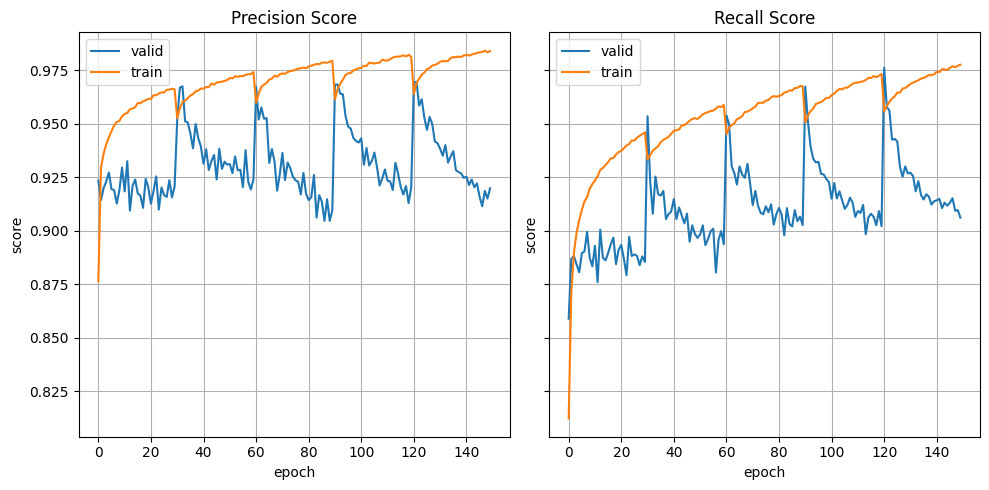

In [19]:
valid_precision_score = [item for history in histories for item in history['val_precision']]
train_precision_score = [item for history in histories for item in history['precision']]
valid_recall_score = [item for history in histories for item in history['val_recall']]
train_recall_score = [item for history in histories for item in history['recall']]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].plot(valid_precision_score, label='valid')
axes[0].plot(train_precision_score, label='train')
axes[0].set_title('Precision Score')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('score')
axes[0].legend()
axes[0].grid()

axes[1].plot(valid_recall_score, label='valid')
axes[1].plot(train_recall_score, label='train')
axes[1].set_title('Recall Score')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('score')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

### **7.5. Embedding Model Preparation**

We only use first shared_node for embedding model

### **7.5.1. Get Dense Embedding Model**

In [20]:
embd_input = Input(shape=(num_dim, ), name='input')
embd_output = training_model.get_layer('shared_node_1')(embd_input)

embd_model = Model(inputs=embd_input, outputs=embd_output, name='embd_inference_model')
embd_model.summary()

Model: "embd_inference_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 384)]             0         
                                                                 
 shared_node_1 (Dense)       (None, 256)               98560     
                                                                 
Total params: 98560 (385.00 KB)
Trainable params: 98560 (385.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **7.5.2. Get LSTM Embedding Model**

In [226]:
%%script skipped # Skipped

embd_input = Input(shape=(num_dim, ), name='input')
embd_x = training_model.get_layer('reshape_node_1')(embd_input)
embd_x = training_model.get_layer('shared_node_1')(embd_x)
embd_x = training_model.get_layer('shared_node_2')(embd_x)
embd_output = training_model.get_layer('shared_node_3')(embd_x)

embd_model = Model(inputs=embd_input, outputs=embd_output, name='embd_inference_model')
embd_model.summary()

Couldn't find program: 'skipped'


### **7.6. Embedding Model Evaluation**

In [21]:
def custom_cosine_similarity(text_1: np.ndarray, text_2: np.ndarray):
    dot_product = np.dot(text_1, text_2)
    norm_text_1 = np.linalg.norm(text_1)
    norm_text_2 = np.linalg.norm(text_2)
    
    similarity = dot_product / (norm_text_1 * norm_text_2)
    return similarity

In [22]:
embd_test_left = embd_model.predict(np.vstack(X_test['text_embedded__left']))
embd_test_right = embd_model.predict(np.vstack(X_test['text_embedded__right']))

embd_similarity = np.array([custom_cosine_similarity(embd_1, embd_2) for embd_1, embd_2 in zip(embd_test_left, embd_test_right)])

6587/6587 [==============================] - 8s 1ms/step


In [23]:
def evaluate_model(similarity_scores: np.ndarray, threshold: float):
  embd_binary_similarity = (similarity_scores > threshold).astype(int)

  precision = precision_score(y_test, embd_binary_similarity)
  recall = recall_score(y_test, embd_binary_similarity)
  f1 = f1_score(y_test, embd_binary_similarity)
  
  return [precision, recall, f1]

In [24]:
threshold_eval = pd.DataFrame([[threshold, *evaluate_model(embd_similarity, threshold)] for threshold in np.linspace(0, 1, 1000)], columns=['threshold', 'precision', 'recall', 'f1'])
threshold_eval.sort_values(by='f1', ascending=False)

,threshold,precision,recall,f1
315,0.315315,0.908723,0.879339,0.893789
314,0.314314,0.907574,0.880143,0.893648
316,0.316316,0.910060,0.877798,0.893638
317,0.317317,0.911038,0.876726,0.893552
318,0.318318,0.912365,0.875251,0.893423
...,...,...,...,...
995,0.995996,1.000000,0.018798,0.036902
996,0.996997,1.000000,0.018697,0.036708
997,0.997998,1.000000,0.018563,0.036450
998,0.998999,1.000000,0.018496,0.036321


<Axes: title={'center': 'Metrics Evaluation'}, xlabel='Threshold', ylabel='Metric score'>

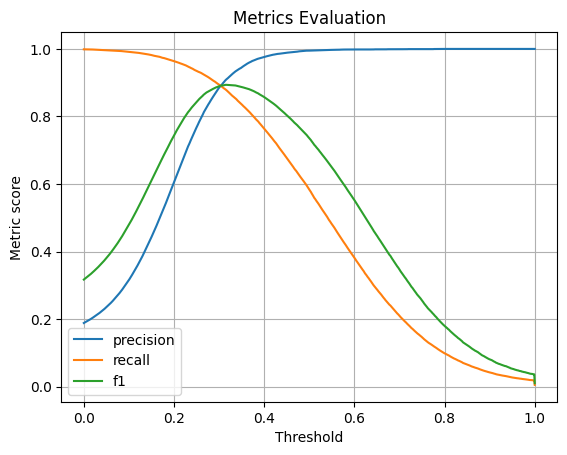

In [25]:
threshold_eval.plot(
  kind='line',
  title='Metrics Evaluation',
  x='threshold',
  xlabel='Threshold',
  ylabel='Metric score',
  grid=True)

In [26]:
model_eval = evaluate_model(embd_similarity, 0.402402)

print(f'Precision: {model_eval[0]:.5f}')
print(f'Recall: {model_eval[1]:.5f}')
print(f'F1: {model_eval[2]:.5f}')

Precision: 0.97722
Recall: 0.76029
F1: 0.85521


### **8. Similarity Search**

### **8.1. Prepare Data**

In [27]:
column_mapper = {
  'id__left': 'id',
  'text_embedded__left': 'vector',
  'id__right': 'id_match',
}

df_sim_search_test = df[df['label'] == 1][['id__left', 'text_embedded__left', 'id__right']].rename(columns=column_mapper)
df_sim_search_test

,id,vector,id_match
6,1827635,"[-0.1291467, 0.02662287, -0.04684974, -0.08061...",1818889.0
27,1605547,"[0.0024032774, -0.029554408, 0.0068566585, 0.0...",1595125.0
35,1272833,"[0.0018792549, 0.025417238, 0.08257131, -0.052...",1269055.0
46,256587,"[0.048316304, -0.050933715, -0.024246735, -0.0...",250396.0
56,852907,"[0.04085875, -0.03561307, 0.015352942, 0.02826...",851491.0
...,...,...,...
702475,277748,"[0.06269118, -0.09506704, 0.030324927, -0.0123...",243893.0
702495,267004,"[-0.053758204, 0.0076490645, 0.021267977, -0.0...",267003.0
702497,1312990,"[-0.030019205, 0.013571095, -0.024307784, 0.03...",1309236.0
702501,1036023,"[0.05396592, 0.01790012, 0.032566354, -0.03994...",989947.0


In [28]:
column_mapper = {
  'id__left': 'id',
  'text_embedded__left': 'vector',
}

df_sim_search_data = df[['id__left', 'text_embedded__left']].rename(columns=column_mapper)
df_sim_search_data = df_sim_search_data[~df_sim_search_data['id'].isin(df_sim_search_test['id'])]
df_sim_search_data

,id,vector
0,1423931,"[-0.073869064, -0.023113009, -0.036643017, 0.0..."
1,1285784,"[0.037364237, -0.0663444, 0.027595308, 0.06272..."
2,80203,"[0.0064626415, 0.049363393, 0.0705011, 0.02903..."
3,217765,"[-0.0657082, 0.032259695, 0.0018165926, -0.068..."
4,72229,"[0.06847505, -0.004994621, 0.017238725, -0.030..."
...,...,...
702507,959973,"[-0.07375773, 0.056716017, -0.039623976, 0.068..."
702508,757533,"[0.0022730783, 0.01744571, 0.014961153, -0.026..."
702509,1272894,"[-0.023455046, -0.015315322, 0.041282535, 0.07..."
702510,1240342,"[-0.010341146, 0.035316605, -0.018016774, -0.0..."


### **8.2. Create Faiss Index**

In [29]:
base_vectors = np.vstack(df_sim_search_data['vector'])
mod_vectors = embd_model.predict(base_vectors)

vector_dim = 256
ids = df_sim_search_data['id']

nlist = 500
quantizer = faiss.IndexFlatIP(vector_dim)
index = faiss.IndexIVFFlat(quantizer, vector_dim, nlist, faiss.METRIC_INNER_PRODUCT)

faiss.normalize_L2(mod_vectors)

index.train(mod_vectors)
index.add_with_ids(mod_vectors, ids)

18845/18845 [==============================] - 54s 3ms/step


### **8.3. Perform Similarity Search**

In [30]:
index.nprobe = 10
k = 10

_base_vector = np.vstack(df_sim_search_test['vector'])
_mod_vectors = embd_model.predict(_base_vector)

faiss.normalize_L2(_mod_vectors)

search_result = index.search(_mod_vectors, k=k)

3109/3109 [==============================] - 6s 1ms/step


### **8.4. Similarity Search Evaluation**

In [31]:
ids_actual = search_result[1]
ids_expected = df_sim_search_test['id_match']

results = []
for id_actual, id_expected in zip(ids_actual, ids_expected):
  if id_expected in id_actual:
    results.append(1)
  else:
    results.append(0)

In [32]:
np.average(results)

0.25354094834085583